<a href="https://colab.research.google.com/github/canibal1/objdet_train_tensorflow_colab/blob/master/object_detection_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/'


%cd
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

In [22]:
%cd /root
!ls
!mkdir datalab


/root
models


In [23]:
%cd ~/datalab

!echo "item { id: 1 name: 'kalem'}" > label_map.pbtxt //buraya name e datasetin ismini veriyoruz.

fileId = '1Q9STh-h79C7HOIzlhBWS2c56Q_lV2Vcz' //bunun anlamı drive a yüklediğin datasetinin paylaşılabilir linkindeki en sonda olan kısım.

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

/root/datalab
Extracted zip file 1Q9STh-h79C7HOIzlhBWS2c56Q_lV2Vcz.zip


In [24]:
%cd ~/datalab/annotations

!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/root/datalab/annotations


In [0]:
%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.
!python setup.py build
!python setup.py install

In [26]:
%cd ~/datalab

!python ~/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record


/root/datalab
/root/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [27]:
%cd ~/datalab

import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/root/datalab


In [28]:
%cd ~/datalab

import re

#filename = '/root/datalab/pretrained_model/pipeline.config'
filename = '/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/root/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/root/datalab/label_map.pbtxt', s)
  f.write(s)

/root/datalab


In [0]:
%cd ~/datalab

!python ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=/root/datalab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500

In [30]:
%cd ~/datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model



/root/datalab
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
360 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-mi

In [67]:
%cd ~/datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/root/datalab


Saving pipeline_1.jpg to pipeline_1.jpg
saved file pipeline_1.jpg


In [0]:
%cd
%cd models/research
!protoc object_detection/protos/*.proto --python_out=.

!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

/root/models/research/object_detection


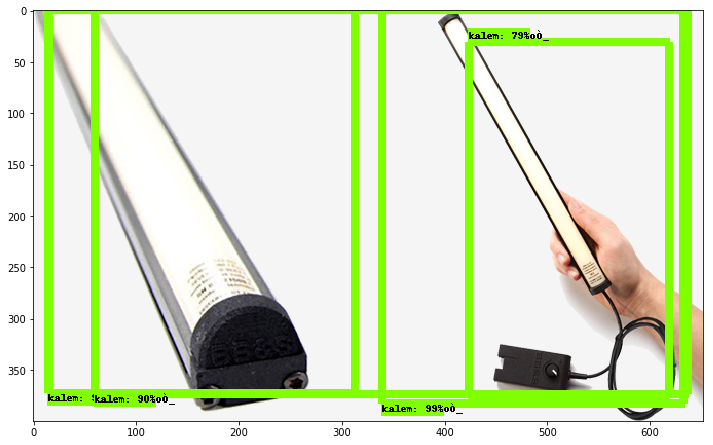

In [68]:

%cd ~/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

MIN_TF_VERSION_MAJOR = 1
MIN_TF_VERSION_MINOR = 9
tf_ver = [int(s) for s in tf.__version__.split('.')]

if tf_ver[0] < MIN_TF_VERSION_MAJOR or (tf_ver[0] == MIN_TF_VERSION_MAJOR and tf_ver[1] < MIN_TF_VERSION_MINOR):
  raise ImportError('Please upgrade your tensorflow installation to v{0}.{1}.* or later!'.format(MIN_TF_VERSION_MAJOR, MIN_TF_VERSION_MINOR))

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/datalab/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/datalab', 'label_map.pbtxt')

NUM_CLASSES = 1




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  


